<a href="https://colab.research.google.com/github/federicopessina/RedditSarcasm/blob/main/Copy_of_main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

## Dataset and Goal

The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0). The task of the project is, given only the parent comment and the Reddit category (subreddit), to predict the probability of a parent comment to receive a sarcastic comment.

  

## Evaluation strategy

Cross-validation.

## Dataset

[Sarcasm on Reddit](https://www.kaggle.com/danofer/sarcasm)

## References

[Khodak, M., Saunshi, N., & Vodrahalli, K. (2017). A large self-annotated corpus for sarcasm](https://arxiv.org/abs/1704.05579)

[Eke, C. I., Norman, A. A., Shuib, L., & Nweke, H. F. (2019). Sarcasm identification in textual data: systematic review, research challenges and open directions. Artificial Intelligence Review, 1-44](https://link.springer.com/article/10.1007/s10462-019-09791-8)

[Joshi, A., Bhattacharyya, P., & Carman, M. J. (2017). Automatic sarcasm detection: A survey. ACM Computing Surveys (CSUR), 50(5), 1-22](https://dl.acm.org/doi/abs/10.1145/3124420)

# Project

In [ ]:
# magic keyword to calculate time of cell run
!pip install ipython-autotime
%load_ext autotime

time: 150 µs (started: 2021-08-23 08:32:27 +00:00)


## Import Dataset

### Kaggle APIs

In [ ]:
!pip install -q kaggle

In [ ]:
# import kaggle json file with user and credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"federicopessina","key":"f9820affe5bfc08ff0b9f028f609feea"}'}

In [ ]:
# create kaggle folder
!mkdir ~/.kaggle

In [ ]:
# copy kaggle.json file to kaggle folder
!cp kaggle.json ~/.kaggle/

In [ ]:
# permission to json file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download kaggle dataset from project
!kaggle datasets download -d danofer/sarcasm

 99% 215M/216M [00:02<00:00, 114MB/s]
100% 216M/216M [00:02<00:00, 101MB/s]


In [ ]:
# unzip downloaded folder
!unzip sarcasm.zip

Archive:  sarcasm.zip
  inflating: test-balanced.csv       
  inflating: test-unbalanced.csv     
  inflating: train-balanced-sarc.csv.gz  
  inflating: train-balanced-sarcasm.csv  


In [ ]:
!pip install scikit-plot
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [ ]:
import time         # calculate running time
import os           # access directory structure
import pandas as pd # data processing
import numpy as np
import math  
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import scikitplot as skplt

import seaborn as sns

### Initialize Dataset


In [ ]:
number_of_rows_to_read = None         # 'None' to read the whole file in script
raw_data = pd.read_csv('/content/train-balanced-sarcasm.csv', delimiter=',', nrows = number_of_rows_to_read, engine="python")
raw_data.name = 'train-balanced-sarcasm.csv'
raw_data.number_of_rows, raw_data.number_of_cols = raw_data.shape

print(f'There are {raw_data.number_of_rows} rows and {raw_data.number_of_cols} columns')

There are 1010826 rows and 10 columns


### Dataset Informations

In [ ]:
raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [ ]:
raw_data.describe()

,label,score,ups,downs
count,1010826.0,1.010826e+06,1.010826e+06,1.010826e+06
mean,0.5,6.885676e+00,5.498885e+00,-1.458629e-01
std,0.5,4.834288e+01,4.127297e+01,3.529689e-01
min,0.0,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.0,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.5,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.0,4.000000e+00,3.000000e+00,0.000000e+00
max,1.0,9.070000e+03,5.163000e+03,0.000000e+00


## Data Cleaning

### Data Selection

Eliminate columns that are not interesting for our research

In [ ]:
raw_data = raw_data[['parent_comment', 'subreddit', 'label']]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   parent_comment  1010826 non-null  object
 1   subreddit       1010826 non-null  object
 2   label           1010826 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 23.1+ MB


### NAs

In [ ]:
raw_data.isna().sum(axis = 0)

parent_comment    0
subreddit         0
label             0
dtype: int64

In [ ]:
na_comments = raw_data["parent_comment"].isna()
na_comments = raw_data[na_comments].index
raw_data.drop(   labels = na_comments,      # Index or column labels to drop.
                axis = 0,                   # Whether to drop labels from the index (0 or ‘index’) or columns (1 or ‘columns’).
                inplace = True)             # If False, return a copy. Otherwise, do operation inplace and return None.

### Standardization

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer # punctuation
from nltk.tokenize import word_tokenize   # word tockenizer
import string                             # string operations
from nltk.corpus import stopwords         # stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')



nltk.download('stopwords')
stop_words_en = stopwords.words("english")

def to_lower(df, column):
  df[column] = df[column].str.lower()
  return df


def remove_numbers(df, column):
  df[column] = df[column].str.replace('\d+', '')
  return df

def underscore_to_space(df, column):
  df[column] = df[column].str.replace('_', ' ')
  return df


def remove_stopwords(df, column, stopword):
  df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword)]))
  return df


def remove_punctuation(df, column):
  df[column] = df[column].str.replace('[^\w\s]', '')
  return df


def tokenize(df, column):
  df[column] = df.apply(lambda row : nltk.word_tokenize(row[column]), axis = 1)
  return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
time: 87.8 ms (started: 2021-08-23 08:33:05 +00:00)


In [ ]:
# initialize cleaned data
cleaned_data = raw_data.copy()

# to lower
cleaned_data = to_lower(cleaned_data, 'parent_comment')
cleaned_data = to_lower(cleaned_data, 'subreddit')

# remove numbers
cleaned_data = remove_numbers(cleaned_data, 'parent_comment')
cleaned_data = remove_numbers(cleaned_data, 'subreddit')

# from underscore to space
cleaned_data = underscore_to_space(cleaned_data, 'parent_comment')
cleaned_data = underscore_to_space(cleaned_data, 'subreddit')

# remove stopwords
cleaned_data = remove_stopwords(cleaned_data, 'parent_comment', stopword = stop_words_en)
cleaned_data = remove_stopwords(cleaned_data, 'subreddit', stopword = stop_words_en)

# remove punctuation
cleaned_data = remove_punctuation(cleaned_data, 'parent_comment')
cleaned_data = remove_punctuation(cleaned_data, 'subreddit')

# print example
cleaned_data.head(15)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


,parent_comment,subreddit,label
0,yeah get argument point id prefer lived nc well,politics,0
1,blazers mavericks the wests seed even carry go...,nba,0
2,theyre favored win,nfl,0
3,deadass kill buzz,blackpeopletwitter,0
4,yep confirm saw tool use that made boy easport...,maddenultimateteam,0
5,find ariana grande sexy,askreddit,0
6,whats weird unsettling trick treat story,askreddit,0
7,probably sephiroth refuse taint greatness my w...,ffbraveexvius,0
8,upgrade spend mainly birthday st im really su...,pcmasterrace,0
9,probably count kanye since rest tour canceled ...,lollapalooza,0


time: 1min 10s (started: 2021-08-23 08:33:29 +00:00)


## Data Exploration

Number of subreddits

In [ ]:
number_of_subreddits = len(cleaned_data["subreddit"].unique())
number_of_subreddits

14675

time: 145 ms (started: 2021-08-23 08:34:48 +00:00)


In [ ]:
cleaned_data.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum]).sort_values(by = 'sum', ascending = False)

,size,mean,sum
subreddit,,,
askreddit,65678,0.401474,26368
politics,39498,0.605398,23912
worldnews,26378,0.642543,16949
leagueoflegends,21037,0.542330,11409
pcmasterrace,18988,0.566674,10760
...,...,...,...
crappycontouring,1,0.000000,0
nutshack,1,0.000000,0
nus,1,0.000000,0


time: 383 ms (started: 2021-08-23 08:34:53 +00:00)


Most frequent subreddits

In [ ]:
!pip install dataframe_image

     |████████████████████████████████| 1.3 MB 36.6 MB/s 
     |████████████████████████████████| 294 kB 69.9 MB/s 
     |████████████████████████████████| 142 kB 58.8 MB/s 
time: 5.19 s (started: 2021-08-23 08:34:58 +00:00)


                    label
subreddit                
worldnews        0.642529
atheism          0.639555
politics         0.605378
news             0.603457
technology       0.600035
pcmasterrace     0.566674
soccer           0.547765
todayilearned    0.547560
leagueoflegends  0.542330
hockey           0.528119
nba              0.526509
nfl              0.509894
videos           0.493425
gaming           0.488661
movies           0.484580
pics             0.484400
funny            0.451474


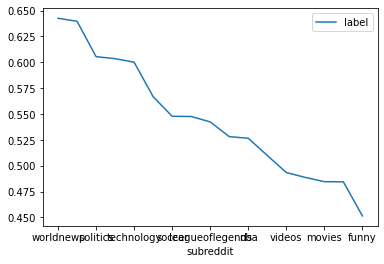

time: 940 ms (started: 2021-08-23 08:35:10 +00:00)


In [ ]:
import dataframe_image as dfi
N_MOST_FREQ_SUBREDDITS = 25

most_frequent_subreddits = cleaned_data["subreddit"].value_counts()[0:N_MOST_FREQ_SUBREDDITS] # get the [:n] most freq subreddit
most_frequent_subreddits = list(most_frequent_subreddits.index)
most_frequent_subreddits_percentual = cleaned_data[raw_data["subreddit"].isin(most_frequent_subreddits)].groupby("subreddit").agg({"label" : "mean"})
most_frequent_subreddits_percentual_sorted = most_frequent_subreddits_percentual.sort_values(by = 'label',
                                                ascending = False)

print(most_frequent_subreddits_percentual_sorted)
most_frequent_subreddits_percentual_sorted.plot()

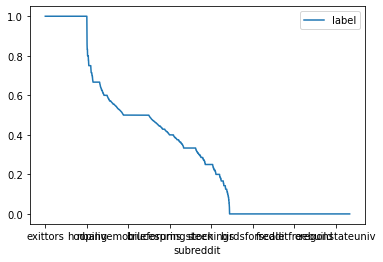

time: 790 ms (started: 2021-08-23 08:35:15 +00:00)


In [ ]:
import dataframe_image as dfi

frequency_subreddits = cleaned_data["subreddit"].value_counts()[0:] # get the [:n] most freq subreddit
frequency_subreddits = list(frequency_subreddits.index)
frequency_subreddits_percentual = cleaned_data[cleaned_data["subreddit"].isin(frequency_subreddits)].groupby("subreddit").agg({"label" : "mean"})
frequency_subreddits_percentual_sorted = frequency_subreddits_percentual.sort_values(by = 'label',
                                                ascending = False)

#dfi.export(frequency_subreddits_percentual_sorted, 'frequency_subreddits_percentual_sorted.png')
#print(frequency_subreddits_percentual_sorted)
frequency_subreddits_percentual_sorted.plot()

### Parent Comment

In [ ]:
cleaned_data_sarcastic = cleaned_data.loc[cleaned_data['label'] == 1]
cleaned_data_sincere = cleaned_data.loc[cleaned_data['label'] == 0]

print(cleaned_data_sarcastic)
print('\n')
print(cleaned_data_sincere)

                                            parent_comment  ... label
33                dumb thing is risking seller account too  ...     1
44       clinton campaign accuses fbi blatant double st...  ...     1
45       anyone else think interesting way mentioned ta...  ...     1
66               heres happens obama gives twitter account  ...     1
69       monday night drinking thread brought infuriati...  ...     1
...                                                    ...  ...   ...
1010821  one calling engineered pathogen reports virus ...  ...     1
1010822  move typical recent donothing approach co emis...  ...     1
1010823              screw disabledive got get church time  ...     1
1010824  ive always unsettled that hear lot jewish peop...  ...     1
1010825  people make laws seem unable grasp countrys ba...  ...     1

[505413 rows x 3 columns]


                                            parent_comment  ... label
0          yeah get argument point id prefer lived nc well  .

In [ ]:
from collections import defaultdict
import string # for punctuation
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py

def generate_ngrams(text, n_gram = 1):
    token = [token.strip(string.punctuation) # remove leading/trailing punctuation
             for token in text.lower().split(" ") # for words in text; lower cased
             if token.strip(string.punctuation) != "" if token not in stop_words_en] # except empty and stop words
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Get the bar chart from sincere parent comment
freq_dict = defaultdict(int)
for sent in cleaned_data_sincere["parent_comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key = lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(30), 'blue')

# Get the bar chart from sarcastic parent comment
freq_dict = defaultdict(int)
for sent in cleaned_data_sarcastic["parent_comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows = 1, cols = 2, vertical_spacing = 0.04,
                          subplot_titles=["Frequent words of sincere parent comment", 
                                          "Frequent words of sarcasm parent comment"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height = 1200, width = 900, paper_bgcolor = 'rgb(233,233,233)', title = "Word Count Plots")
py.iplot(fig, filename = 'word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



time: 55.4 s (started: 2021-08-23 08:35:21 +00:00)


In [ ]:
# BIGRAMS

# Get the bar chart from sincere parent comment
freq_dict = defaultdict(int)
for sent in cleaned_data_sincere["parent_comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key = lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(30), 'orange')

# Get the bar chart from sarcastic parent comment
freq_dict = defaultdict(int)
for sent in cleaned_data_sarcastic["parent_comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere parent comment", 
                                          "Frequent bigrams of sarcasm parent comment"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height = 1200, width = 900, paper_bgcolor = 'rgb(233,233,233)', title = "Bigram Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



time: 1min 4s (started: 2021-08-23 08:36:17 +00:00)


In [ ]:
# TRIGRAMS
# Get the bar chart from sincere parent comment
freq_dict = defaultdict(int)
for sent in cleaned_data_sincere["parent_comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(30), 'green')

# Get the bar chart from sarcastic parent comment
freq_dict = defaultdict(int)
for sent in cleaned_data_sarcastic["parent_comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere parent comments", 
                                          "Frequent bigrams of sarcasm parent comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height = 1200, width = 900, paper_bgcolor = 'rgb(233,233,233)', title = "Bigram Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



time: 1min 4s (started: 2021-08-23 08:37:21 +00:00)


## Preprocessing

## Train/Validation Split

### Initialization

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split( cleaned_data, 
                                        test_size = 0.15, 
                                        random_state = 123) # shuffling applied before applying the split
print(train_data.shape)
print(test_data.shape)

(859202, 3)
(151624, 3)
time: 227 ms (started: 2021-08-23 08:38:50 +00:00)


In [ ]:
train_subreddit = train_data['subreddit']
test_subreddit = test_data['subreddit']

train_parent_comment = train_data['parent_comment']
test_parent_comment = test_data['parent_comment']

train_label = train_data['label']
test_label = test_data['label']

time: 7.45 ms (started: 2021-08-23 08:38:54 +00:00)


### Check balancing

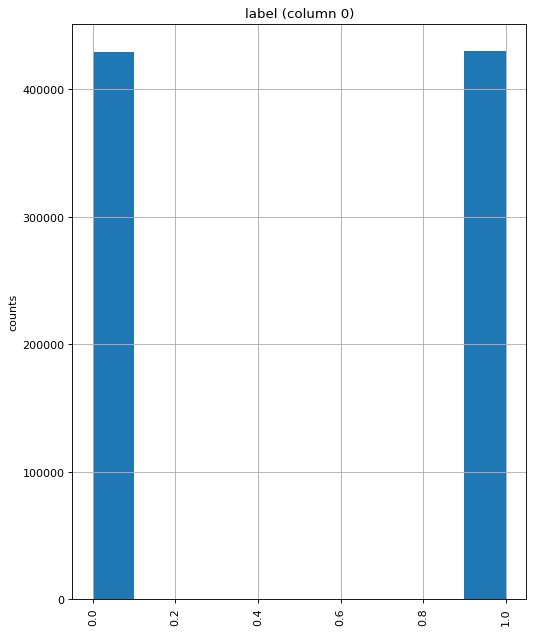

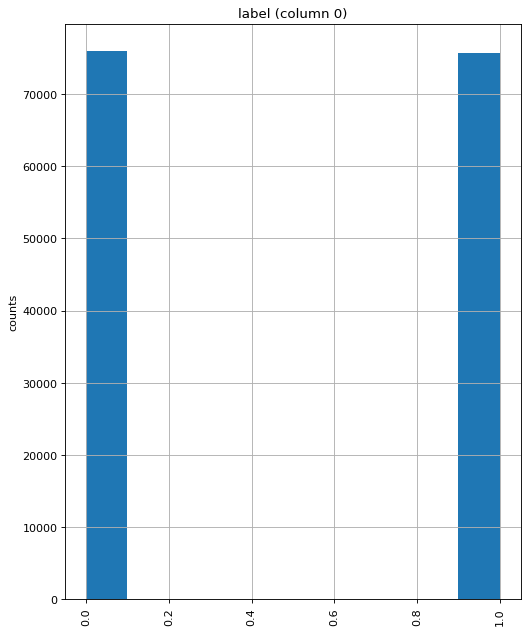

time: 2.65 s (started: 2021-08-23 08:39:02 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Distribution graphs (histogram/bar graph) of column data
def plot_per_column_distribution(df, number_of_graphs_shown, number_of_graph_per_rows, filename):
    nunique = df.nunique() # Count distinct observations over requested axis
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # pick columns that have between 1 and 50 unique values
    _number_of_rows, _number_of_cols = df.shape
    _column_names = list(df)
    _number_of_graph_rows = (_number_of_cols + number_of_graph_per_rows - 1) / number_of_graph_per_rows
    plt.figure(num = None, figsize = (6 * number_of_graph_per_rows, 8 * _number_of_graph_rows), dpi = 80, facecolor = 'w', edgecolor = 'k')
    
    for i in range(min(_number_of_cols, number_of_graphs_shown)):
        plt.subplot(_number_of_graph_rows, number_of_graph_per_rows, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{_column_names[i]} (column {i})')
    
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    
    # save image
    plt.savefig(filename + ".png", 
                bbox_inches = 'tight', 
                pad_inches = 0.15) # savefig() before show()
    # show image
    plt.show()


plot_per_column_distribution(train_data, 10, 5, "train_data_count_barplot")
plot_per_column_distribution(test_data, 10, 5, "train_data_count_barplot")

## Feature Engineering

In [ ]:
def add_length(data, column):
  data[f'{column} length'] = data[column].str.len()
  return data

time: 1.85 ms (started: 2021-08-23 08:39:11 +00:00)


## Model

### Supervised

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import scikitplot as skplt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_validate
from nltk import punkt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

time: 21.5 ms (started: 2021-08-23 08:39:18 +00:00)


In [ ]:
def evaluate_results(model, test_df):
    # Predict class labels using the learner function
    test_df['pred'] = model.predict(test_df['parent_comment'])
    y_true = test_df['label']
    y_pred = test_df['pred']
    target_names = ['non sarcastic', 'sarcastic']

    # Print the Confusion Matrix
    results_log = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    results_df_log = pd.DataFrame(results_log).transpose()
    print(results_df_log)
    matrix = confusion_matrix(y_true,  y_pred)
    sns.heatmap(pd.DataFrame(matrix), 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel('Predictions')
    plt.xlabel('Actual')
    
    model_score = sklearn.metrics.precision_score(y_pred, y_true, average='macro')
    return model_score

time: 10.5 ms (started: 2021-08-23 08:39:21 +00:00)


In [ ]:
token_count_matrix = CountVectorizer(   strip_accents = 'unicode', 
                                        stop_words = stop_words_en, 
                                        min_df = 0.0001, 
                                        max_df = 0.70)
token_count_matrix

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.7, max_features=None, min_df=0.0001,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

time: 15.8 ms (started: 2021-08-23 08:39:24 +00:00)


In [ ]:
train_bow = token_count_matrix.fit_transform(train_parent_comment)
train_bow

<859202x10805 sparse matrix of type '<class 'numpy.int64'>'
	with 8682482 stored elements in Compressed Sparse Row format>

time: 15.3 s (started: 2021-08-23 08:39:27 +00:00)


In [ ]:
tfidf_trans_normalized = TfidfTransformer()
train_tfidf = tfidf_trans_normalized.fit_transform(train_bow)

time: 488 ms (started: 2021-08-23 08:39:49 +00:00)


#### Logistic Regression

make a classifier using Logistic Regression only for comment attribute with a Bag of Words

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(random_state = 123)
cross_validate(log_reg_model, 
                train_bow, 
                train_label, 
                cv = 2, 
                scoring = "accuracy", 
                n_jobs =- 1)

{'fit_time': array([10.22645307,  9.81177521]),
 'score_time': array([0.06817245, 0.10598731]),
 'test_score': array([0.56508016, 0.56556433])}

time: 11.9 s (started: 2021-08-23 08:40:28 +00:00)


In [ ]:
log_reg_model = LogisticRegression(random_state = 42, 
                                    penalty = "elasticnet", 
                                    solver = "saga")

pipeline = Pipeline([
    ('vect', token_count_matrix),
    ('tftrans', tfidf_trans_normalized),
    ('model', log_reg_model)
])

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__max_features': (5000, 15000, 30000),
    'model__l1_ratio': (0.0, 0.25, 0.50, 0.75, 1.0)
}

time: 4.69 ms (started: 2021-08-23 08:41:21 +00:00)


In [ ]:
from sklearn.model_selection import GridSearchCV
grid_logreg = GridSearchCV(pipeline, param_grid, scoring = "accuracy", cv = 2, n_jobs =- 1)
grid_logreg.fit(train_parent_comment, train_label)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



KeyboardInterrupt: ignored

time: 1h 33min 20s (started: 2021-08-23 08:41:27 +00:00)


In [ ]:
print(grid_logreg.best_index_)
print(grid_logreg.best_params_)
print(grid_logreg.best_score_)
print(grid_logreg.__dict__)

In [ ]:
# evaluate model performance
import sklearn
model_score = evaluate_results(grid_logreg, test_data)

In [ ]:
# confusion matrix
cm = pd.DataFrame(confusion_matrix(test_label, predictions), 
                    index = ['NOT SARCASTIC', 'SARCASTIC'],
                    columns=['NOT SARCASTIC', 'SARCASTIC'])

fig = plt.figure(figsize = (8, 6))
ax = sns.heatmap(cm, annot = True,
                    cbar = False, 
                    cmap = 'Blues',
                    linewidths = 0.5,
                    fmt = '.0f')
ax.set_title('Logistic Regression Prediction Confusion Matrix',
                fontsize = 16,
                y = 1.25)
ax.set_ylabel('actual', fontsize = 14)
ax.set_xlabel('prediction', fontsize = 14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize = 12)

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#token_count_matrix = CountVectorizer(strip_accents='unicode', stop_words = stop_words_en, min_df = 0.0001, max_df = 0.70)
#tf_trans = TfidfTransformer()

# instantiate the Naive Bayes model
nb_model = MultinomialNB()

# instantiate Pipeline for model 
model = Pipeline([
    ('vect', token_count_matrix),
    ('tftrans', tfidf_trans_normalized),
    ('model', nb_model)
])

# instantiate dictionary with parameters
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__max_features': (5000, 15000, 30000)
}

# instantiate a GridSearchCV object
grid_nb = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "accuracy", cv = 2, n_jobs =- 1)

In [ ]:
%%time
grid_nb.fit(train_parent_comment, train_label)

In [ ]:
print(f'Naive Bayes predictor best score is : {grid_nb.best_score_}')
for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, grid_nb.best_params_[param_name]))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# print accuracy score
predictions = grid_nb.predict(test_parent_comment) 
print('Accuracy Score: {:.2%}'.format(accuracy_score(test_label, predictions)),'\n') 

# Evaluate model performance
model_score = evaluate_results(grid_nb, test_data)

In [ ]:
# confusion matrix
cm = pd.DataFrame(confusion_matrix(test_label, predictions), 
                    index = ['NOT SARCASTIC', 'SARCASTIC'],
                    columns=['NOT SARCASTIC', 'SARCASTIC'])

fig = plt.figure(figsize = (8, 6))
ax = sns.heatmap(cm, annot = True,
                    cbar = False, 
                    cmap = 'Blues',
                    linewidths = 0.5,
                    fmt = '.0f')
ax.set_title('Naive Bayes Prediction Confusion Matrix',
                fontsize = 16,
                y = 1.25)
ax.set_ylabel('actual', fontsize = 14)
ax.set_xlabel('prediction', fontsize = 14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize = 12)

In [ ]:
testphrases = ['yes, sure...']
for testphrase in testphrases:
    resultx = grid_nb.predict([testphrase]) # use model_bayes for predictions with the other model
    dict = {0: 'non sarcastic', 1: 'sarcastic'}
    print(testphrase + '-> ' + dict[resultx[0]])

#### Support Vector Machine

In [ ]:
from sklearn.linear_model import SGDClassifier

svm_model = SGDClassifier(  penalty = "elasticnet", 
                            random_state = 42, 
                            n_jobs =- 1)

model = Pipeline([
    ('vect', token_count_matrix),
    ('tftrans', tfidf_trans_normalized),
    ('model', svm_model)
])

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__max_features': (5000, 15000, 30000),
    'model__l1_ratio': (0.0, 0.15, 0.40, 0.60, 0.85, 1.0)
}

grid_svm = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "accuracy", cv = 2, n_jobs =- 1)

In [ ]:
%%time
grid_svm.fit(train_parent_comment, train_label)

In [ ]:
print(f'Support Vector Machines predictor best score is : {grid_svm.best_score_}')
for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, grid_svm.best_params_[param_name]))

In [ ]:
%%time
# recreate the vectorizer and transformer so they are not fit yet
vect = CountVectorizer(strip_accents = 'unicode', 
                        stop_words = stopwords, 
                        min_df = 0.0001, 
                        max_df = 0.70, 
                        max_features = 15000, 
                        ngram_range = (1, 3))
# create the NB model
nb_model = MultinomialNB()

# instantiate Pipeline for model 
chosen_model = Pipeline([
    ('vect', token_count_matrix),
    ('tftrans', tfidf_trans_normalized),
    ('model', nb_model)
])

chosen_model.fit(train_parent_comment, train_label)

Evaluate the Model

In [ ]:
predictions = chosen_model.predict(test_parent_comment)
print('Accuracy Score: {:.2%}'.format(accuracy_score(test_label, predictions)),'\n')

# Evaluate model performance
model_score = evaluate_results(chosen_model, test_data)

In [ ]:
# Plot Confusion Matrix

cm = pd.DataFrame(confusion_matrix(test_label, predictions), 
                  index = ['NON SARCASTIC','SARCASTIC'],
                  columns = ['NON SARCASTIC','SARCASTIC'])

fig = plt.figure(figsize = (8,6))
ax = sns.heatmap(cm, annot = True, 
                 cbar = False, 
                 cmap = 'Blues',
                 linewidths = 0.5,
                 fmt = '.0f')
ax.set_title('SVM Prediction Confusion Matrix', 
             fontsize = 16, 
             y = 1.25)
ax.set_ylabel('ACTUAL', fontsize = 14)
ax.set_xlabel('PREDICTED', fontsize = 14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)

### Unsupervised

#### Neural Network

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

time: 3.15 s (started: 2021-08-23 10:14:59 +00:00)


In [ ]:
# Separate the csv into sentences and labels
sentences = []
labels = []

time: 2.11 ms (started: 2021-08-23 10:15:03 +00:00)


In [ ]:
# Setting tokenizer properties
vocab_size = 10000
oov_tok = "<oov>"

time: 1.83 ms (started: 2021-08-23 10:15:03 +00:00)


In [ ]:
# Fit the tokenizer on Training data
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_parent_comment)

time: 18.9 s (started: 2021-08-23 10:15:03 +00:00)


In [ ]:
word_index = tokenizer.word_index

time: 1.24 ms (started: 2021-08-23 10:15:21 +00:00)


In [ ]:
# Setting the padding properties
max_length = 100
trunc_type='post'
padding_type='post'

time: 2.01 ms (started: 2021-08-23 10:15:21 +00:00)


In [ ]:
# Creating padded sequences from train and test data
training_sequences = tokenizer.texts_to_sequences(train_parent_comment)
training_padded = pad_sequences(training_sequences, 
                                maxlen = max_length, 
                                padding = padding_type, 
                                truncating = trunc_type)

time: 20.8 s (started: 2021-08-23 10:15:21 +00:00)


In [ ]:
testing_sequences = tokenizer.texts_to_sequences(test_parent_comment)
testing_padded = pad_sequences(testing_sequences, 
                               maxlen = max_length, 
                               padding = padding_type, 
                               truncating = trunc_type)

time: 3.26 s (started: 2021-08-23 10:15:42 +00:00)


In [ ]:
# Setting the model parameters
embedding_dim = 16

time: 1.63 ms (started: 2021-08-23 10:15:46 +00:00)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                              embedding_dim, # default 'uniform'
                              input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

time: 300 ms (started: 2021-08-23 10:15:46 +00:00)


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

time: 13.8 ms (started: 2021-08-23 10:15:46 +00:00)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________
time: 4.48 ms (started: 2021-08-23 10:15:46 +00:00)


In [ ]:
# Converting the lists to numpy arrays for Tensorflow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(train_label)
testing_padded = np.array(testing_padded)
testing_labels = np.array(test_label)

time: 265 ms (started: 2021-08-23 10:15:46 +00:00)


In [ ]:
# Training the model
num_epochs = 30

time: 1.87 ms (started: 2021-08-23 10:15:46 +00:00)


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2021-08-23 10:15:46--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.232.15.19, 52.44.51.219, 34.239.30.50, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.232.15.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  47.1MB/s    in 0.3s    

2021-08-23 10:15:47 (47.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://515e-35-245-26-196.ngrok.io
time: 1.41 s (started: 2021-08-23 10:15:46 +00:00)


In [ ]:
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         write_images=True)

history = model.fit( x = training_padded, 
                    y = training_labels, 
                    epochs = num_epochs, 
                    validation_data = (testing_padded, testing_labels), 
                    verbose = 2,
                    callbacks = [tbCallBack])

Epoch 1/30
26851/26851 - 106s - loss: 0.6781 - accuracy: 0.5674 - val_loss: 0.6720 - val_accuracy: 0.5852
Epoch 2/30
26851/26851 - 97s - loss: 0.6691 - accuracy: 0.5884 - val_loss: 0.6722 - val_accuracy: 0.5847
Epoch 3/30
26851/26851 - 91s - loss: 0.6659 - accuracy: 0.5934 - val_loss: 0.6744 - val_accuracy: 0.5797
Epoch 4/30
26851/26851 - 95s - loss: 0.6633 - accuracy: 0.5978 - val_loss: 0.6732 - val_accuracy: 0.5844
Epoch 5/30
26851/26851 - 89s - loss: 0.6606 - accuracy: 0.6014 - val_loss: 0.6740 - val_accuracy: 0.5839
Epoch 6/30
26851/26851 - 89s - loss: 0.6580 - accuracy: 0.6040 - val_loss: 0.6761 - val_accuracy: 0.5830
Epoch 7/30
26851/26851 - 92s - loss: 0.6557 - accuracy: 0.6074 - val_loss: 0.6775 - val_accuracy: 0.5800
Epoch 8/30
26851/26851 - 84s - loss: 0.6536 - accuracy: 0.6097 - val_loss: 0.6787 - val_accuracy: 0.5815
Epoch 9/30
26851/26851 - 82s - loss: 0.6516 - accuracy: 0.6116 - val_loss: 0.6804 - val_accuracy: 0.5771
Epoch 10/30
26851/26851 - 81s - loss: 0.6493 - accurac

In [ ]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

time: 76.9 ms (started: 2021-08-23 11:00:11 +00:00)


In [ ]:
# Install
! npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.1
added 22 packages from 22 contributors in 2.044s
time: 3.95 s (started: 2021-08-23 11:00:11 +00:00)


In [ ]:
# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

time: 73.8 ms (started: 2021-08-23 11:00:15 +00:00)


In [ ]:
# Get url
! cat url.txt

time: 205 ms (started: 2021-08-23 11:00:15 +00:00)


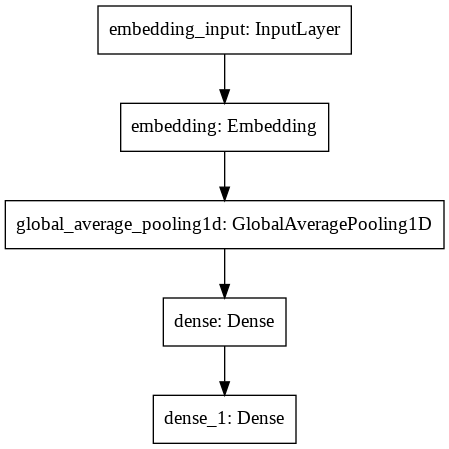

time: 6.55 s (started: 2021-08-23 11:00:15 +00:00)


In [ ]:
!pip install Graphviz
import graphviz
!pip install pydot
import pydot
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)